# PhysicalLineEmulator — Demonstration (User Codebase Import)

This notebook demonstrates realistic single-line synthesis using **your** `PhysicalLineEmulator` implementation (which imports limb-darkening and line-profile functions from `spice.spectrum.*`).

**Key assumptions of this realization:**  
- `spectral_parameters` vector order: **[Teff [K], logg (cgs), mu]**  
- Limb darkening and line profile are selected by **string names**, internally mapped via `get_limb_darkening_law_id` and `get_line_profile_id`.  
- Broadening *inside the emulator* includes **thermal** + **microturbulence** (Gaussian σ) and a Lorentzian **γ** that scales with Teff and g.  
- Optional μ‑dependent **convective shift** controlled by `use_convective_shift` and `v_conv0`.  
- Instrumental, rotational, and RV broadening are handled elsewhere in your pipeline.

> If the import cell below fails, edit the path/module to point to your local codebase and re‑run.


In [1]:
# --- Configure your codebase import here ---
import sys, os, importlib
from spice.spectrum import PhysicalLineEmulator
import matplotlib
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Simple helpers
def make_loglam(lam_min_A, lam_max_A, npts=2000):
    return jnp.linspace(jnp.log10(lam_min_A), jnp.log10(lam_max_A), int(npts))

def plot_spectrum(loglam, flux, title="", xlabel="Wavelength (Å)"):
    wl = 10 ** loglam
    plt.figure()
    plt.plot(wl, flux)
    plt.xlabel(xlabel)
    plt.ylabel("Relative Flux")
    if title:
        plt.title(title)
    plt.show()

# Quadrature-based disk integration over μ in [0,1]
def flux_from_emulator(emulator, log_wavelengths, Teff, logg, mus_number=20):
    roots, weights = np.polynomial.legendre.leggauss(mus_number)
    mu_arr = (roots + 1) / 2.0
    w_arr  = weights / 2.0

    total = 0.0
    for m, wt in zip(mu_arr, w_arr):
        # Build full parameter vector [Teff, logg, mu]
        sp = jnp.array([Teff, logg, float(m)], dtype=jnp.float64)
        # Use the new API path (μ from parameters) via the compatibility layer:
        I_pair = emulator.intensity(log_wavelengths, float(m), sp)
        I_mu = I_pair[:, 0]
        total = total + wt * I_mu * m
    return 2 * math.pi * total  # relative flux


## Quick sanity check

Instantiate `PhysicalLineEmulator` with a simple configuration and compute intensity and disk-integrated flux.


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_36600/1610987366.py:29: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sp = jnp.array([Teff, logg, float(m)], dtype=jnp.float64)


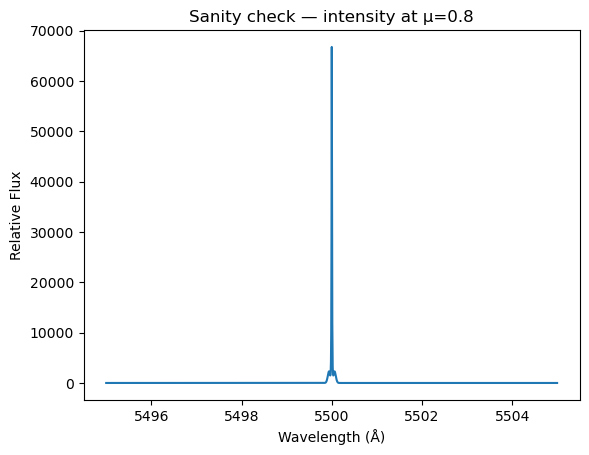

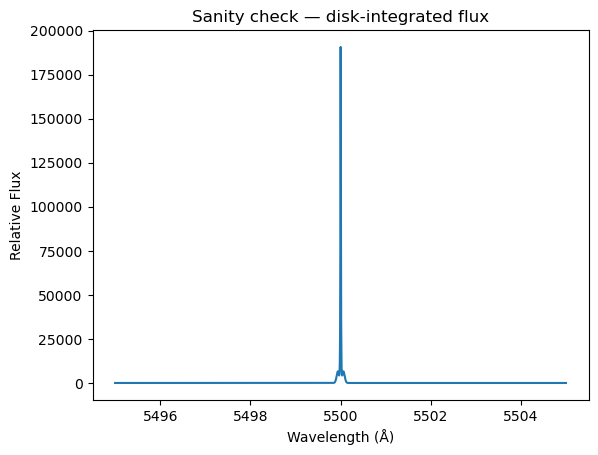

In [3]:
# If you imported manually, ensure PLE points to your class:
# from spice.spectrum.emulator_physical import PhysicalLineEmulator as PLE

try:
    # Minimal instance (edit line_profile_kind/limb_law to match your registered names)
    emu = PhysicalLineEmulator(
        line_center=5500.0,
        line_depth=0.3,
        atomic_mass=56.0,
        v_micro=2.0,
        gamma0=0.05,
        line_profile_kind="voigt",
        limb_law="linear",
        limb_coeffs=(0.6,),
        use_convective_shift=False,
        gamma_g_alpha=0.5,
    )
    loglam = make_loglam(5495.0, 5505.0, npts=2500)
    params = jnp.array([5777.0, 4.44, 0.8])

    I = emu.intensity(loglam, float(params[2]), params)[:, 0]
    F = flux_from_emulator(emu, loglam, Teff=params[0], logg=params[1], mus_number=24)

    plot_spectrum(loglam, I, title="Sanity check — intensity at μ=0.8")
    plot_spectrum(loglam, F, title="Sanity check — disk-integrated flux")
except NameError as e:
    print("Define PLE by importing your PhysicalLineEmulator class, then rerun this cell.")

## Example 1 — Fe I 5250.2 Å: Gaussian vs Voigt

- Solar-like star (`Teff=5800 K`, `logg=4.44`), neutral iron line, moderate depth.  
- Compare Gaussian vs Voigt to visualize wing contributions.


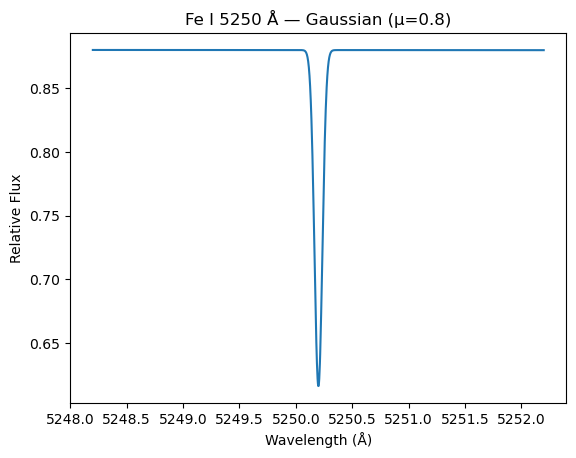

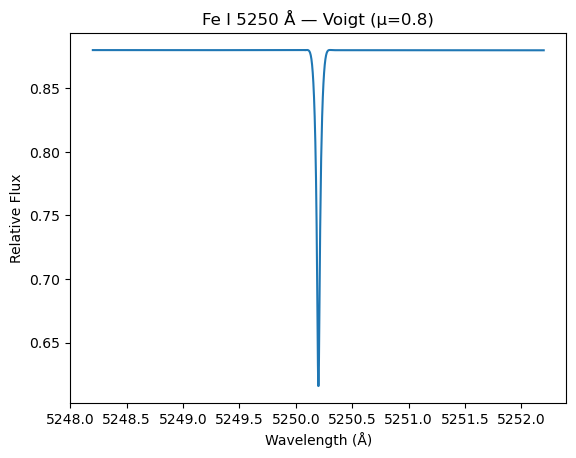

In [4]:
Teff = 5800.0
logg = 4.44
fe_mass_u = 55.845
lam0 = 5250.2
loglam = make_loglam(lam0 - 2.0, lam0 + 2.0, npts=3000)

emu_g = PhysicalLineEmulator(
    line_center=lam0, line_depth=0.3, atomic_mass=fe_mass_u,
    v_micro=1.5, gamma0=0.02, line_profile_kind="gaussian",
    limb_law="linear", limb_coeffs=(0.6,), use_convective_shift=False
)

emu_v = PhysicalLineEmulator(
    line_center=lam0, line_depth=0.3, atomic_mass=fe_mass_u,
    v_micro=1.5, gamma0=0.02, line_profile_kind="voigt",
    limb_law="linear", limb_coeffs=(0.6,), use_convective_shift=False
)

I_g = emu_g.intensity(loglam, 0.8, jnp.array([Teff, logg, 0.8]))[:, 0]
I_v = emu_v.intensity(loglam, 0.8, jnp.array([Teff, logg, 0.8]))[:, 0]

plot_spectrum(loglam, I_g, title="Fe I 5250 Å — Gaussian (μ=0.8)")
plot_spectrum(loglam, I_v, title="Fe I 5250 Å — Voigt (μ=0.8)")

## Example 2 — Hα 6562.8 Å: limb darkening and μ‑dependence

- Hydrogen line with strong wings → Voigt profile.  
- Compare intensities at different μ for several limb‑darkening laws.


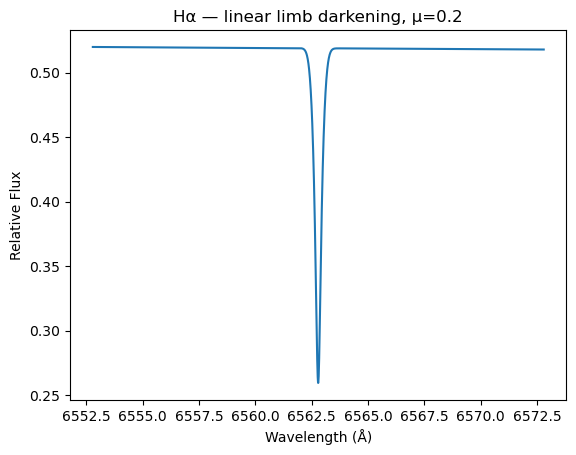

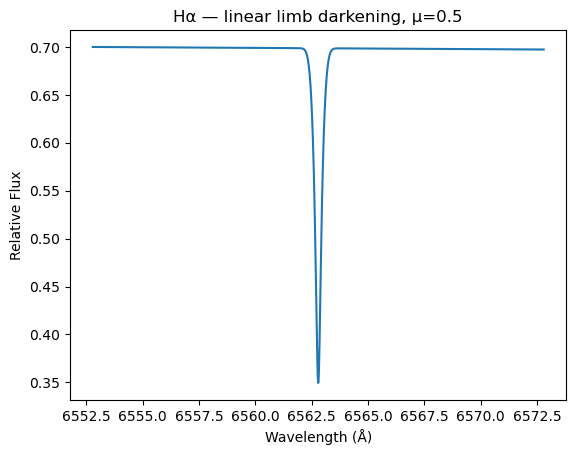

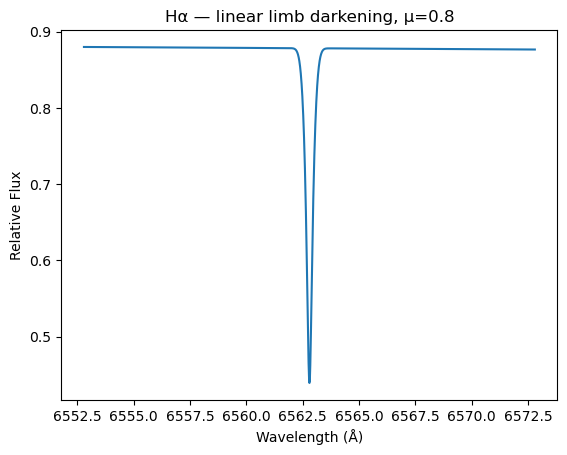

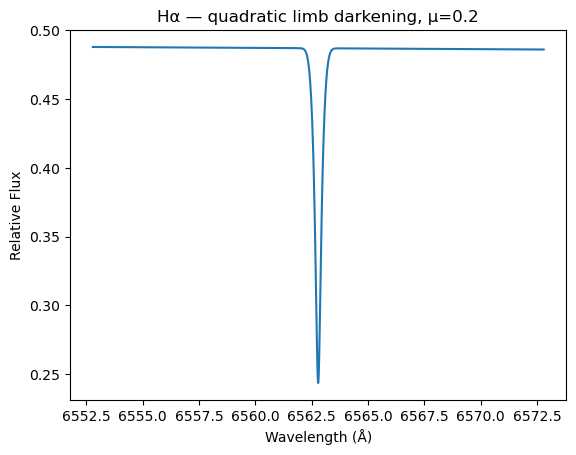

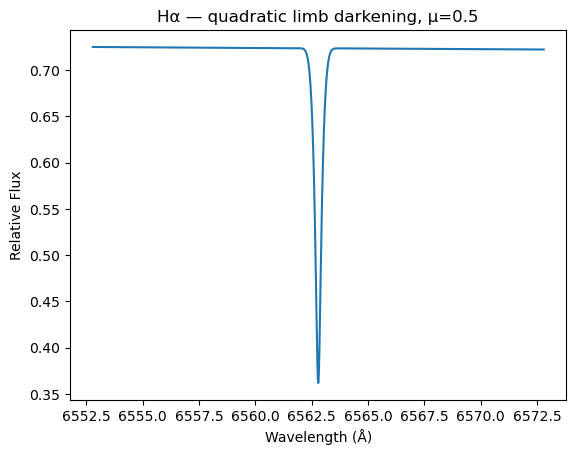

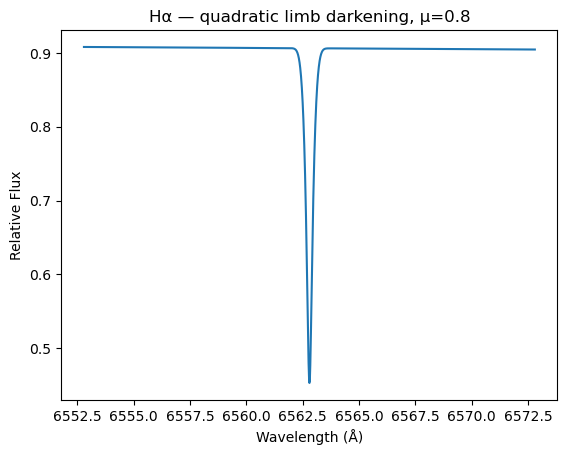

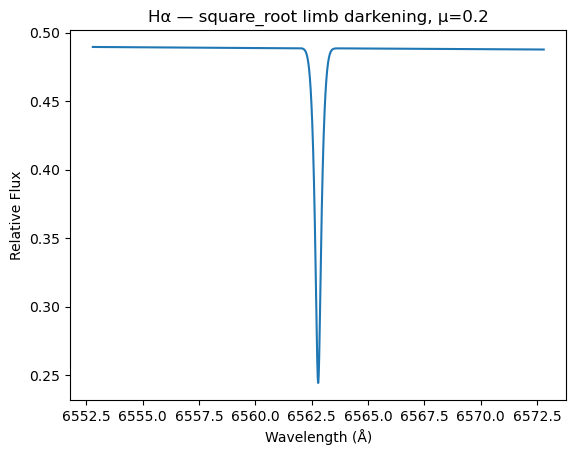

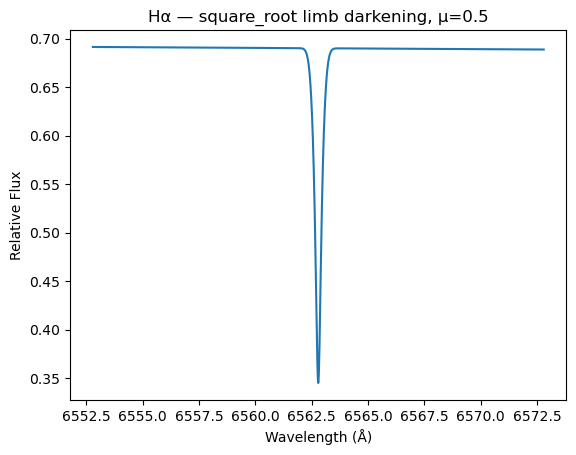

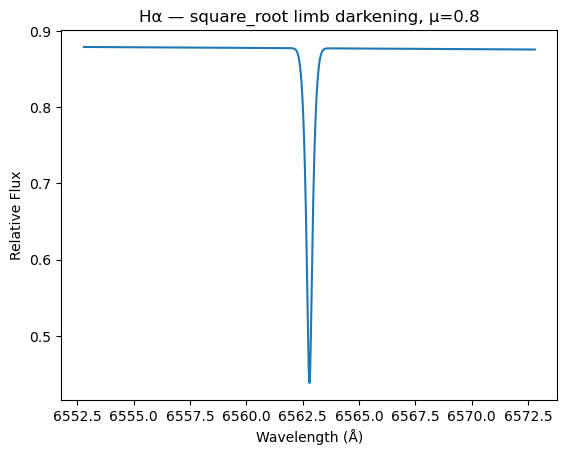

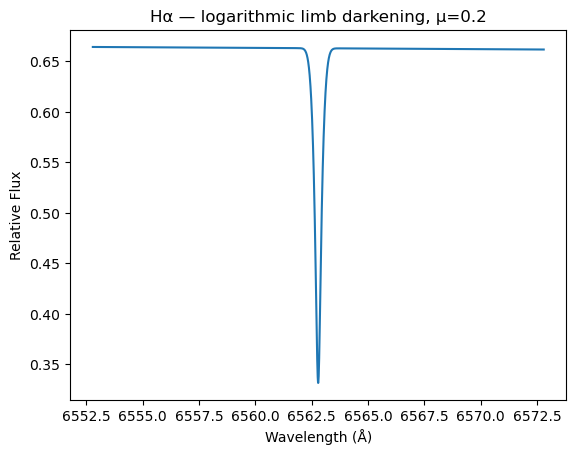

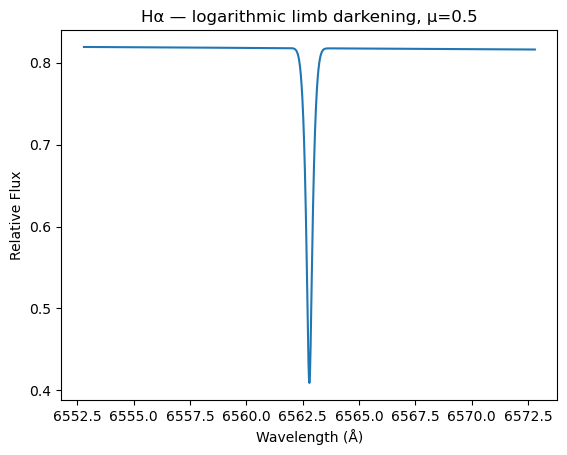

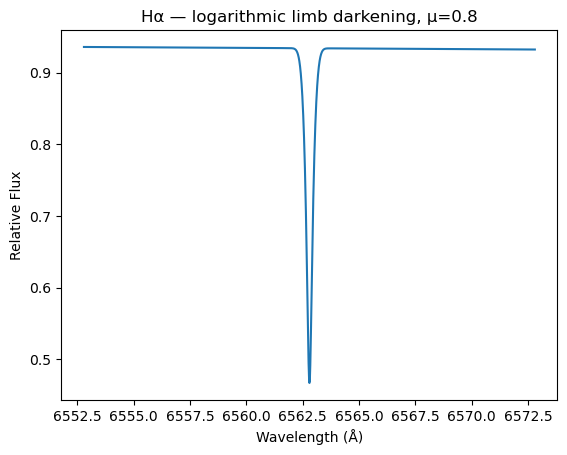

In [5]:
Teff = 6000.0
logg = 4.3
h_mass_u = 1.008
lam0 = 6562.8
loglam = make_loglam(lam0 - 10.0, lam0 + 10.0, npts=4000)

laws = [
    ("linear", (0.6,)),
    ("quadratic", (0.4, 0.3)),
    ("square_root", (0.5, 0.2)),
    ("logarithmic", (0.5, 0.2)),
]

for law, coeffs in laws:
    emu = PhysicalLineEmulator(
        line_center=lam0, line_depth=0.5, atomic_mass=h_mass_u,
        v_micro=3.0, gamma0=0.1, line_profile_kind="voigt",
        limb_law=law, limb_coeffs=coeffs, use_convective_shift=True, v_conv0=0.5
    )
    for mu in [0.2, 0.5, 0.8]:
        I = emu.intensity(loglam, mu, jnp.array([Teff, logg, mu]))[:, 0]
        plot_spectrum(loglam, I, title=f"Hα — {law} limb darkening, μ={mu}")

## Example 3 — Ca II 8542 Å: sensitivity to $T_{\rm eff}$ and $\log g$

`gamma` in your emulator scales like  
\( \gamma = \gamma_0 (T/5777)^{-0.7} (g/g_\odot)^{\alpha} \), with \( g/g_\odot = 10^{\log g - 4.44} \).  
Varying Teff and logg shifts the core/wing balance.


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_36600/1610987366.py:29: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sp = jnp.array([Teff, logg, float(m)], dtype=jnp.float64)
/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_36600/1610987366.py:29: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sp = jnp.array([Teff, logg, float(m)], dtype=jnp.float64)


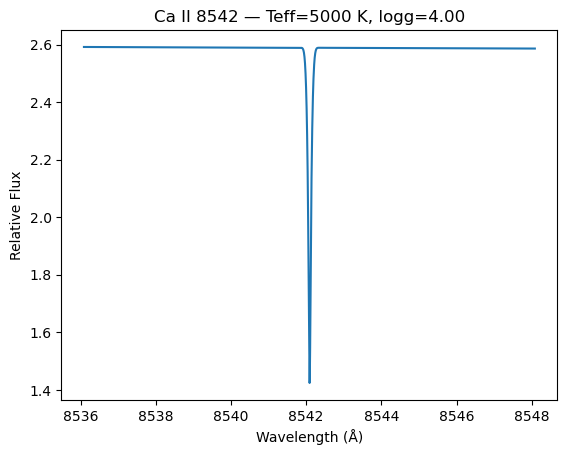

/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_36600/1610987366.py:29: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sp = jnp.array([Teff, logg, float(m)], dtype=jnp.float64)


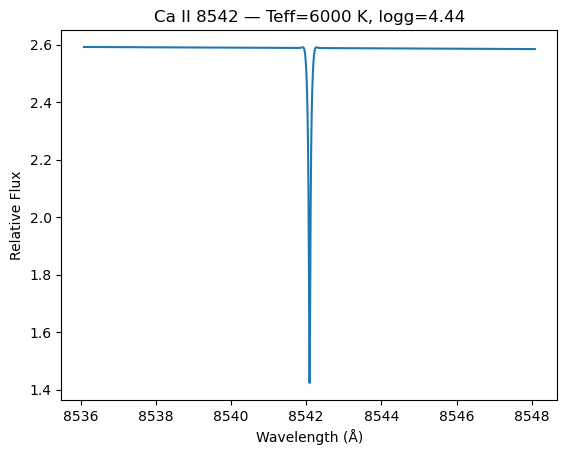

/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_36600/1610987366.py:29: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sp = jnp.array([Teff, logg, float(m)], dtype=jnp.float64)


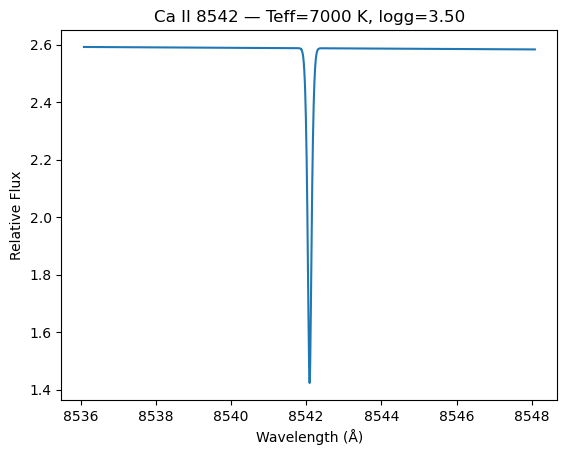

In [6]:
ca_mass_u = 40.078
lam0 = 8542.09
loglam = make_loglam(lam0 - 6.0, lam0 + 6.0, npts=4000)

grid = [
    (5000.0, 4.0),
    (6000.0, 4.44),
    (7000.0, 3.5),
]

for Teff_i, logg_i in grid:
    emu = PhysicalLineEmulator(
        line_center=lam0, line_depth=0.45, atomic_mass=ca_mass_u,
        v_micro=2.0, gamma0=0.05, line_profile_kind="voigt",
        limb_law="quadratic", limb_coeffs=(0.4, 0.25), gamma_g_alpha=0.5
    )
    F = flux_from_emulator(emu, loglam, Teff=Teff_i, logg=logg_i, mus_number=24)
    plot_spectrum(loglam, F, title=f"Ca II 8542 — Teff={Teff_i:.0f} K, logg={logg_i:.2f}")

## Example 4 — μ‑dependent convective shift

When `use_convective_shift=True`, the line center shifts by an amount proportional to \((1-\mu)\). Visualize the shift on a metal line.


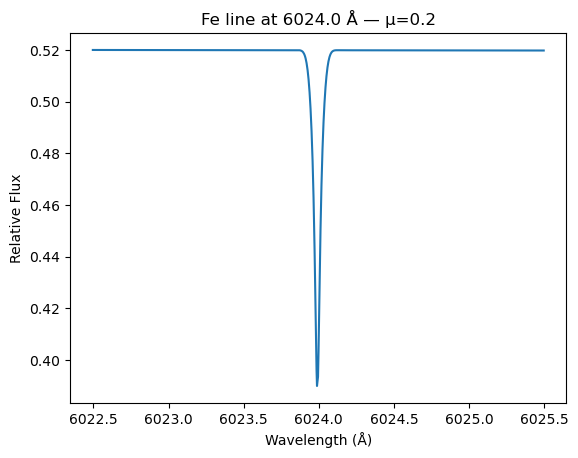

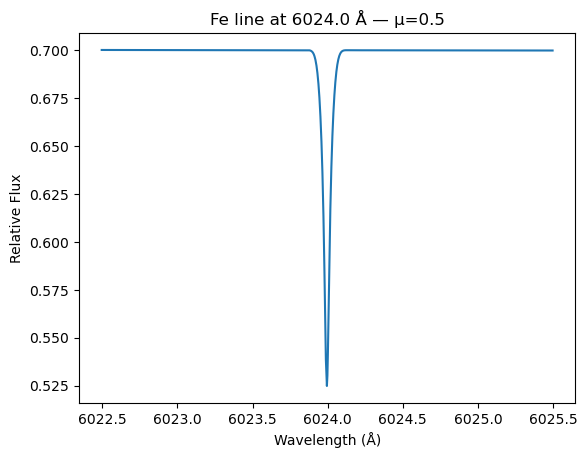

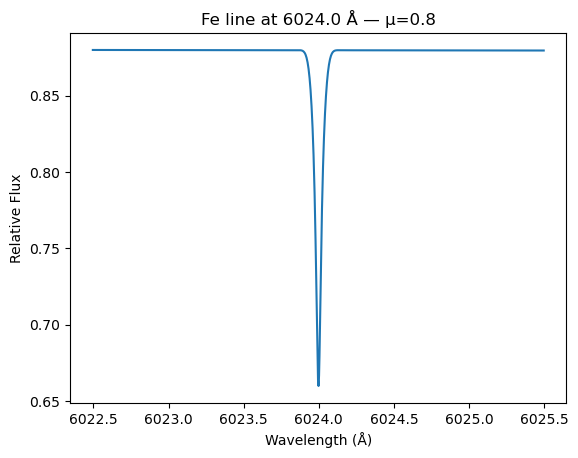

In [7]:
Teff = 5800.0
logg = 4.44
fe_mass_u = 55.845
lam0 = 6024.0
loglam = make_loglam(lam0 - 1.5, lam0 + 1.5, npts=2000)

emu = PhysicalLineEmulator(
    line_center=lam0, line_depth=0.25, atomic_mass=fe_mass_u,
    v_micro=1.5, gamma0=0.02, line_profile_kind="voigt",
    limb_law="linear", limb_coeffs=(0.6,), use_convective_shift=True, v_conv0=0.6
)

for mu in [0.2, 0.5, 0.8]:
    I = emu.intensity(loglam, mu, jnp.array([Teff, logg, mu]))[:, 0]
    plot_spectrum(loglam, I, title=f"Fe line at {lam0} Å — μ={mu}")

## Appendix — Using a line catalog row

If you maintain a CSV catalog of lines (e.g., from VALD/NIST/STARK‑B), you can parameterize the emulator per line:

```python
import pandas as pd
cat = pd.read_csv("merged_line_catalog.csv")
row = cat.iloc[0]

emu = PLE(
    line_center=row.wavelength_A,
    line_depth=0.3,
    atomic_mass=row.atomic_mass_u,
    v_micro=(row.v_micro_kms_default if hasattr(row, 'v_micro_kms_default') and not np.isnan(row.v_micro_kms_default) else 2.0),
    gamma0=(row.gamma0_A if hasattr(row, 'gamma0_A') and not np.isnan(row.gamma0_A) else 0.05),
    line_profile_kind=(row.profile_kind if isinstance(row.profile_kind, str) else "voigt"),
    limb_law="quadratic", limb_coeffs=(0.4, 0.25)
)

loglam = make_loglam(row.wavelength_A - 3.0, row.wavelength_A + 3.0, npts=3000)
Teff, logg, mu = 5800.0, 4.44, 0.8
I = emu.intensity(loglam, mu, jnp.array([Teff, logg, mu]))[:,0]
plot_spectrum(loglam, I, title=f"{row.element} {int(row.ion)} at {row.wavelength_A:.2f} Å (μ={mu})")
```
